## Import Package

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
# collect spread ratio of two stocks as numpy array
close1= pd.read_csv("../input/pair-trading-dataset/F.csv").iloc[-2490:-1, :]["Close"].values
close2 = pd.read_csv("../input/pair-trading-dataset/GM.csv").iloc[-2490:-1, :]["Close"].values
spread = close1 / close2

In [3]:
spread, spread.shape

(array([0.47633138, 0.47514791, 0.46608186, ..., 0.24348917, 0.23902747,
        0.23381405]),
 (2489,))

In [4]:
time = np.array(list(range(len(spread))))
series = spread

In [5]:
# split dataset into train and validation part
time_train = time[:2000]
series_train = series[:2000]
series_train = np.reshape(series_train, (-1, 1))

time_validation = time[2000:]
series_validation = series[2000:]

In [6]:
series_train.shape, series_validation.shape

((2000, 1), (489,))

## Build Input Pipeline for Training

In [7]:
# convert numpy array to Tensorflow Dataset object
dataset = tf.data.Dataset.from_tensor_slices(series_train)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float64>

In [8]:
# split dataset into many windows
dataset = dataset.window(size=21, shift=1, drop_remainder=True)
dataset

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>

In [9]:
# convert each window to a batch
dataset = dataset.map(lambda window: window.batch(21))
dataset

<MapDataset shapes: DatasetSpec(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorShape([]))>

In [10]:
# flatten each batch
dataset = dataset.flat_map(lambda batch: batch)
dataset

<FlatMapDataset shapes: (None, 1), types: tf.float64>

In [11]:
# shuffle the order of batch
dataset = dataset.shuffle(buffer_size=2000)
dataset

<ShuffleDataset shapes: (None, 1), types: tf.float64>

In [12]:
# split each batch into input and output
dataset = dataset.map(lambda batch: (batch[:-1], batch[-1]))
dataset

<MapDataset shapes: ((None, 1), (1,)), types: (tf.float64, tf.float64)>

In [13]:
# integrate 32 batchs/examples into a "batch" for training
dataset = dataset.batch(32)
dataset

<BatchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [14]:
# prefatch Tensorflow Dataset object to enhance efficiency of training process
train_dataset = dataset.prefetch(1)
train_dataset

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
for b in train_dataset:
    print(b)
    print()

## Define Model

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=(20, 1)))
# model.add(keras.layers.Dense(units=128, input_shape=(20, 1), activation="relu"))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            128       
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 60,895
Trainable params: 60,895
Non-trainable params: 0
____________________________________________________

In [18]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(), metrics=["mae"])

## Train Model

In [19]:
model.fit(x=train_dataset, epochs=100, verbose=1)

Epoch 1/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0151 - mae: 0.0762
Epoch 2/100
62/62 [==============================] - 1s 9ms/step - loss: 5.9717e-04 - mae: 0.0194
Epoch 3/100
62/62 [==============================] - 1s 10ms/step - loss: 2.1403e-04 - mae: 0.0115
Epoch 4/100
62/62 [==============================] - 0s 6ms/step - loss: 1.7016e-04 - mae: 0.0100
Epoch 5/100
62/62 [==============================] - 0s 6ms/step - loss: 1.6384e-04 - mae: 0.0098
Epoch 6/100
62/62 [==============================] - 0s 6ms/step - loss: 1.7254e-04 - mae: 0.0101
Epoch 7/100
62/62 [==============================] - 0s 6ms/step - loss: 1.6793e-04 - mae: 0.0099
Epoch 8/100
62/62 [==============================] - 0s 6ms/step - loss: 1.6447e-04 - mae: 0.0098
Epoch 9/100
62/62 [==============================] - 0s 8ms/step - loss: 1.7292e-04 - mae: 0.0102
Epoch 10/100
62/62 [==============================] - 1s 8ms/step - loss: 1.7137e-04 - mae: 0.0101
Epoch 11/100
62/62 [=

In [20]:
ans = []

for idx in range(2000, len(series)):
    arr = series[idx-20:idx]
    arr = np.reshape(arr, (1, 20, 1))
    out = model.predict(arr)[0]
    ans.append(out)

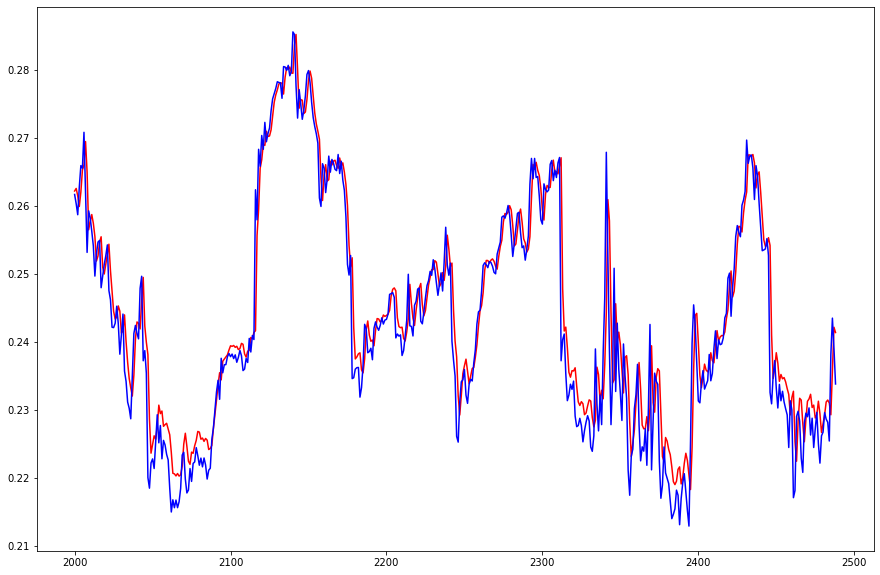

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(time_validation, ans, color="red")
plt.plot(time_validation, series_validation, color="blue")

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
mean_absolute_error(ans, series_validation)

0.003605913710465112